In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import statsmodels.api as sm

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_24344\2912014205.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
def check_stationary(series):

    # Perform Augmented Dickey-Fuller Test
    adf_test = sm.tsa.adfuller(series)

    # Extract and print the test results
    adf_statistic = adf_test[0]
    p_value = adf_test[1]
    critical_values = adf_test[4]

    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)
    print("Critical Values:", critical_values)

    # Interpret the results
    if p_value < 0.05:
        print("The time series is likely stationary (reject the null hypothesis)")
    else:
        print("The time series is likely non-stationary (fail to reject the null hypothesis)")

In [10]:
cnt_join = pd.read_csv("series/count_join.csv")
max_hate = pd.read_csv("series/max_hate.csv")
sum_hate = pd.read_csv("series/sum_hate.csv")
avg_hate = pd.read_csv("series/avg_hate.csv")
max_news = pd.read_csv("series/max_news.csv")
sum_news = pd.read_csv("series/sum_news.csv")
avg_news = pd.read_csv("series/avg_news.csv")
cnt_news = pd.read_csv("series/cnt_news.csv")

In [6]:
check_stationary(cnt_join['rate'])
check_stationary(max_news['max'])
check_stationary(sum_news['sum'])
check_stationary(avg_news['avg'])
check_stationary(cnt_news['cnt'])

ADF Statistic: -2.5568332703996104
p-value: 0.10225112119252094
Critical Values: {'1%': -3.444162847239118, '5%': -2.8676311169658177, '10%': -2.5700143303792107}
The time series is likely non-stationary (fail to reject the null hypothesis)
ADF Statistic: -4.22054632504077
p-value: 0.00060807470674292
Critical Values: {'1%': -3.444133731419755, '5%': -2.8676183066831036, '10%': -2.5700075029117166}
The time series is likely stationary (reject the null hypothesis)
ADF Statistic: -4.2822649098238985
p-value: 0.00047669613734356537
Critical Values: {'1%': -3.444162847239118, '5%': -2.8676311169658177, '10%': -2.5700143303792107}
The time series is likely stationary (reject the null hypothesis)
ADF Statistic: -3.86185827795749
p-value: 0.0023341873116884703
Critical Values: {'1%': -3.444133731419755, '5%': -2.8676183066831036, '10%': -2.5700075029117166}
The time series is likely stationary (reject the null hypothesis)
ADF Statistic: -3.641472962471575
p-value: 0.005015897242436088
Critica

In [19]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import plotly.express as px
import plotly.graph_objects as go

# Generate or load your multivariate time series data (replace with your actual data)
# Example data with two variables (var1 and var2)
data = pd.DataFrame({
    'max': max_news['max'],
    'sum': sum_news['sum'],
    'avg': avg_news['avg'],
    'cnt': cnt_news['cnt'],
})

# Split the data into training and testing sets (adjust as needed)
train_data = data.iloc[:-20, :]
test_data = data.iloc[-20:, :]

# Fit the VAR model
model = VAR(train_data)
model_fitted = model.fit()

# Check the optimal lag order (AIC criterion)
lag_order = model_fitted.k_ar
print("Optimal Lag Order:", lag_order)

# Forecast future values
forecast = model_fitted.forecast(train_data.values[-lag_order:], steps=len(test_data))

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(forecast, columns=train_data.columns)

fig = go.Figure()

# Add training data, actual test data, and forecasted data for var1
fig.add_trace(go.Scatter(x=train_data.index, y=train_data['max'], mode='lines', name='Training Data - max'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['max'], mode='lines', name='Actual Test Data - max'))
fig.add_trace(go.Scatter(x=test_data.index, y=forecast_df['max'], mode='lines+markers', name='Forecasted Data - max'))

# Add training data, actual test data, and forecasted data for var2
fig.add_trace(go.Scatter(x=train_data.index, y=train_data['sum'], mode='lines', name='Training Data - sum'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['sum'], mode='lines', name='Actual Test Data - sum'))
fig.add_trace(go.Scatter(x=test_data.index, y=forecast_df['sum'], mode='lines+markers', name='Forecasted Data - sum'))

# Add training data, actual test data, and forecasted data for var3
fig.add_trace(go.Scatter(x=train_data.index, y=train_data['avg'], mode='lines', name='Training Data - avg'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['avg'], mode='lines', name='Actual Test Data - avg'))
fig.add_trace(go.Scatter(x=test_data.index, y=forecast_df['avg'], mode='lines+markers', name='Forecasted Data - avg'))

# Add training data, actual test data, and forecasted data for var4
fig.add_trace(go.Scatter(x=train_data.index, y=train_data['cnt'], mode='lines', name='Training Data - cnt'))
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['cnt'], mode='lines', name='Actual Test Data - cnt'))
fig.add_trace(go.Scatter(x=test_data.index, y=forecast_df['cnt'], mode='lines+markers', name='Forecasted Data - cnt'))

# Customize the layout
fig.update_layout(
    title="VAR Forecasting",
    xaxis_title="Time",
    yaxis_title="Values",
    showlegend=True
)

# Show the interactive plot
fig.show()

Optimal Lag Order: 1


In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

# Load or generate your multivariate time series data
# Example data with four variables (var1, var2, var3, var4)
data = pd.DataFrame({
    'count_join': cnt_join['cnt_hate'],
    'max_hate': max_hate['max'],
    'sum_hate': sum_hate['sum'],
    'avg_hate': avg_hate['avg'],
    #'max': max_news['max'],
    #'sum': sum_news['sum'],
    'avg': avg_news['avg'],
    'cnt': cnt_news['cnt'],
})

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Define sequence length and forecasting horizon
sequence_length = 10
forecast_horizon = 1

# Create input-output pairs
X, y = [], []
for i in range(len(scaled_data) - sequence_length - forecast_horizon + 1):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length:i+sequence_length+forecast_horizon])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
split_ratio = 0.9
split_index = int(split_ratio * len(X))
X_train, X_test, y_train, y_test = X[:split_index], X[split_index:], y[:split_index], y[split_index:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, X_train.shape[2])))
model.add(Dense(y_train.shape[2]))  # Output layer with one neuron per variable

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the scaled predictions and actual values
predicted_values = scaler.inverse_transform(predictions.reshape(-1, y_train.shape[2]))
actual_values = scaler.inverse_transform(y_test.reshape(-1, y_train.shape[2]))

# Calculate RMSE for each variable
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values, multioutput='raw_values'))

# Print RMSE for each variable
for i, var_name in enumerate(data.columns):
    print(f"RMSE for {var_name}: {rmse[i]}")


Epoch 1/100
426/426 - 2s - loss: 0.0391 - 2s/epoch - 5ms/step
Epoch 2/100
426/426 - 1s - loss: 0.0375 - 1s/epoch - 3ms/step
Epoch 3/100
426/426 - 1s - loss: 0.0373 - 1s/epoch - 3ms/step
Epoch 4/100
426/426 - 1s - loss: 0.0372 - 1s/epoch - 3ms/step
Epoch 5/100
426/426 - 1s - loss: 0.0371 - 1s/epoch - 3ms/step
Epoch 6/100
426/426 - 1s - loss: 0.0371 - 1s/epoch - 3ms/step
Epoch 7/100
426/426 - 1s - loss: 0.0370 - 1s/epoch - 3ms/step
Epoch 8/100
426/426 - 1s - loss: 0.0370 - 1s/epoch - 3ms/step
Epoch 9/100
426/426 - 1s - loss: 0.0370 - 1s/epoch - 3ms/step
Epoch 10/100
426/426 - 1s - loss: 0.0369 - 1s/epoch - 3ms/step
Epoch 11/100
426/426 - 1s - loss: 0.0370 - 1s/epoch - 3ms/step
Epoch 12/100
426/426 - 1s - loss: 0.0368 - 1s/epoch - 3ms/step
Epoch 13/100
426/426 - 1s - loss: 0.0369 - 1s/epoch - 3ms/step
Epoch 14/100
426/426 - 1s - loss: 0.0369 - 1s/epoch - 3ms/step
Epoch 15/100
426/426 - 1s - loss: 0.0368 - 1s/epoch - 3ms/step
Epoch 16/100
426/426 - 1s - loss: 0.0368 - 1s/epoch - 3ms/step
E

In [42]:
# Print RMSE for each variable
for i, var_name in enumerate(data.columns):
    print(f"RMSE for {var_name}: {rmse[i]}")

RMSE for count_join: 28.07933292314717
RMSE for max_hate: 0.003526999067703577
RMSE for sum_hate: 22.52889318955074
RMSE for avg_hate: 0.013277381001791497
RMSE for avg: 122.26863636079878
RMSE for cnt: 12.207263295239336


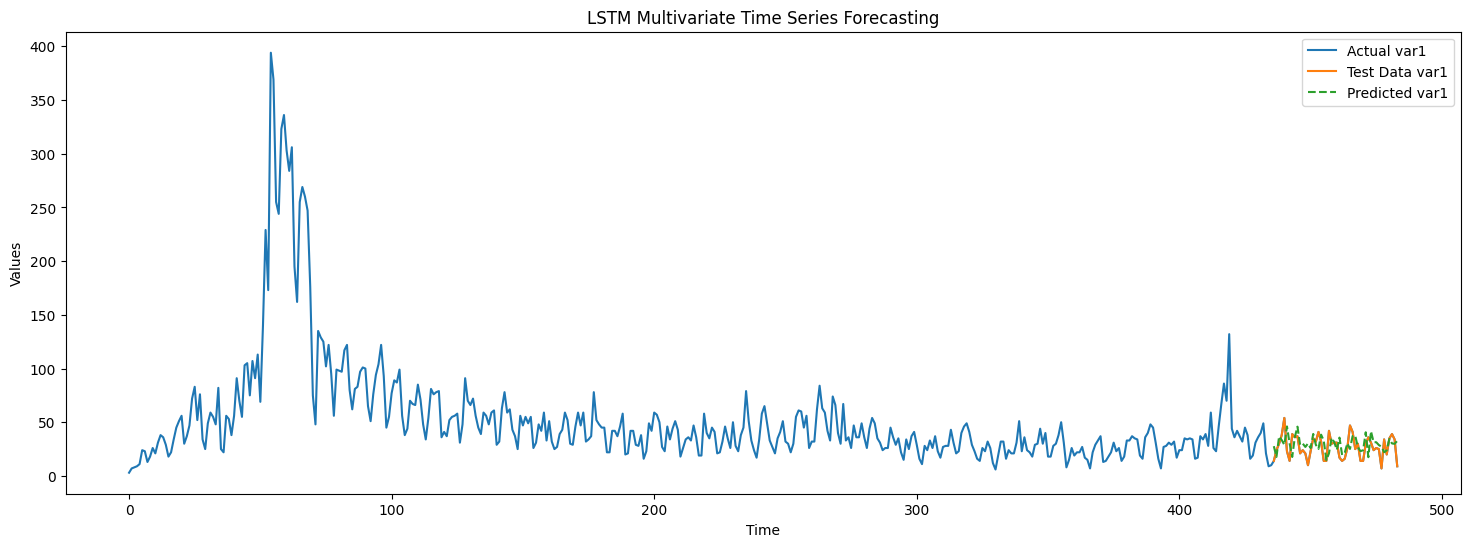

In [45]:
scaled_data_inverse = scaler.inverse_transform(scaled_data)

index = 5

# Plot the entire series, training, testing, and predicted data
plt.figure(figsize=(18, 6))
plt.plot(scaled_data_inverse[:, index], label='Actual var1')
plt.plot(np.arange(len(scaled_data_inverse) - len(y_test), len(scaled_data_inverse)), actual_values[:, index], label='Test Data var1')
plt.plot(np.arange(len(scaled_data_inverse) - len(y_test), len(scaled_data_inverse)), predicted_values[:, index], label='Predicted var1', linestyle='--')


plt.legend()
plt.title("LSTM Multivariate Time Series Forecasting")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()